In [ ]:
import sys
import os

# Adjust the path to point to your src directory
sys.path.insert(0, os.path.abspath('../../src'))

import xarray as xr
from icpoes.utils import average_wavelengths
from icpoes.utils import select_vars_by_element
from matplotlib import pyplot as plt

from icpoes.plotting import bar_by_sample
from icpoes.plotting import bar_by_species

ds = xr.open_dataset('../../data/soils_errors.nc')

FileNotFoundError: [Errno 2] No such file or directory: '/Users/angus/work/icp_oes/src/notebooks/data/soils_errors.nc'

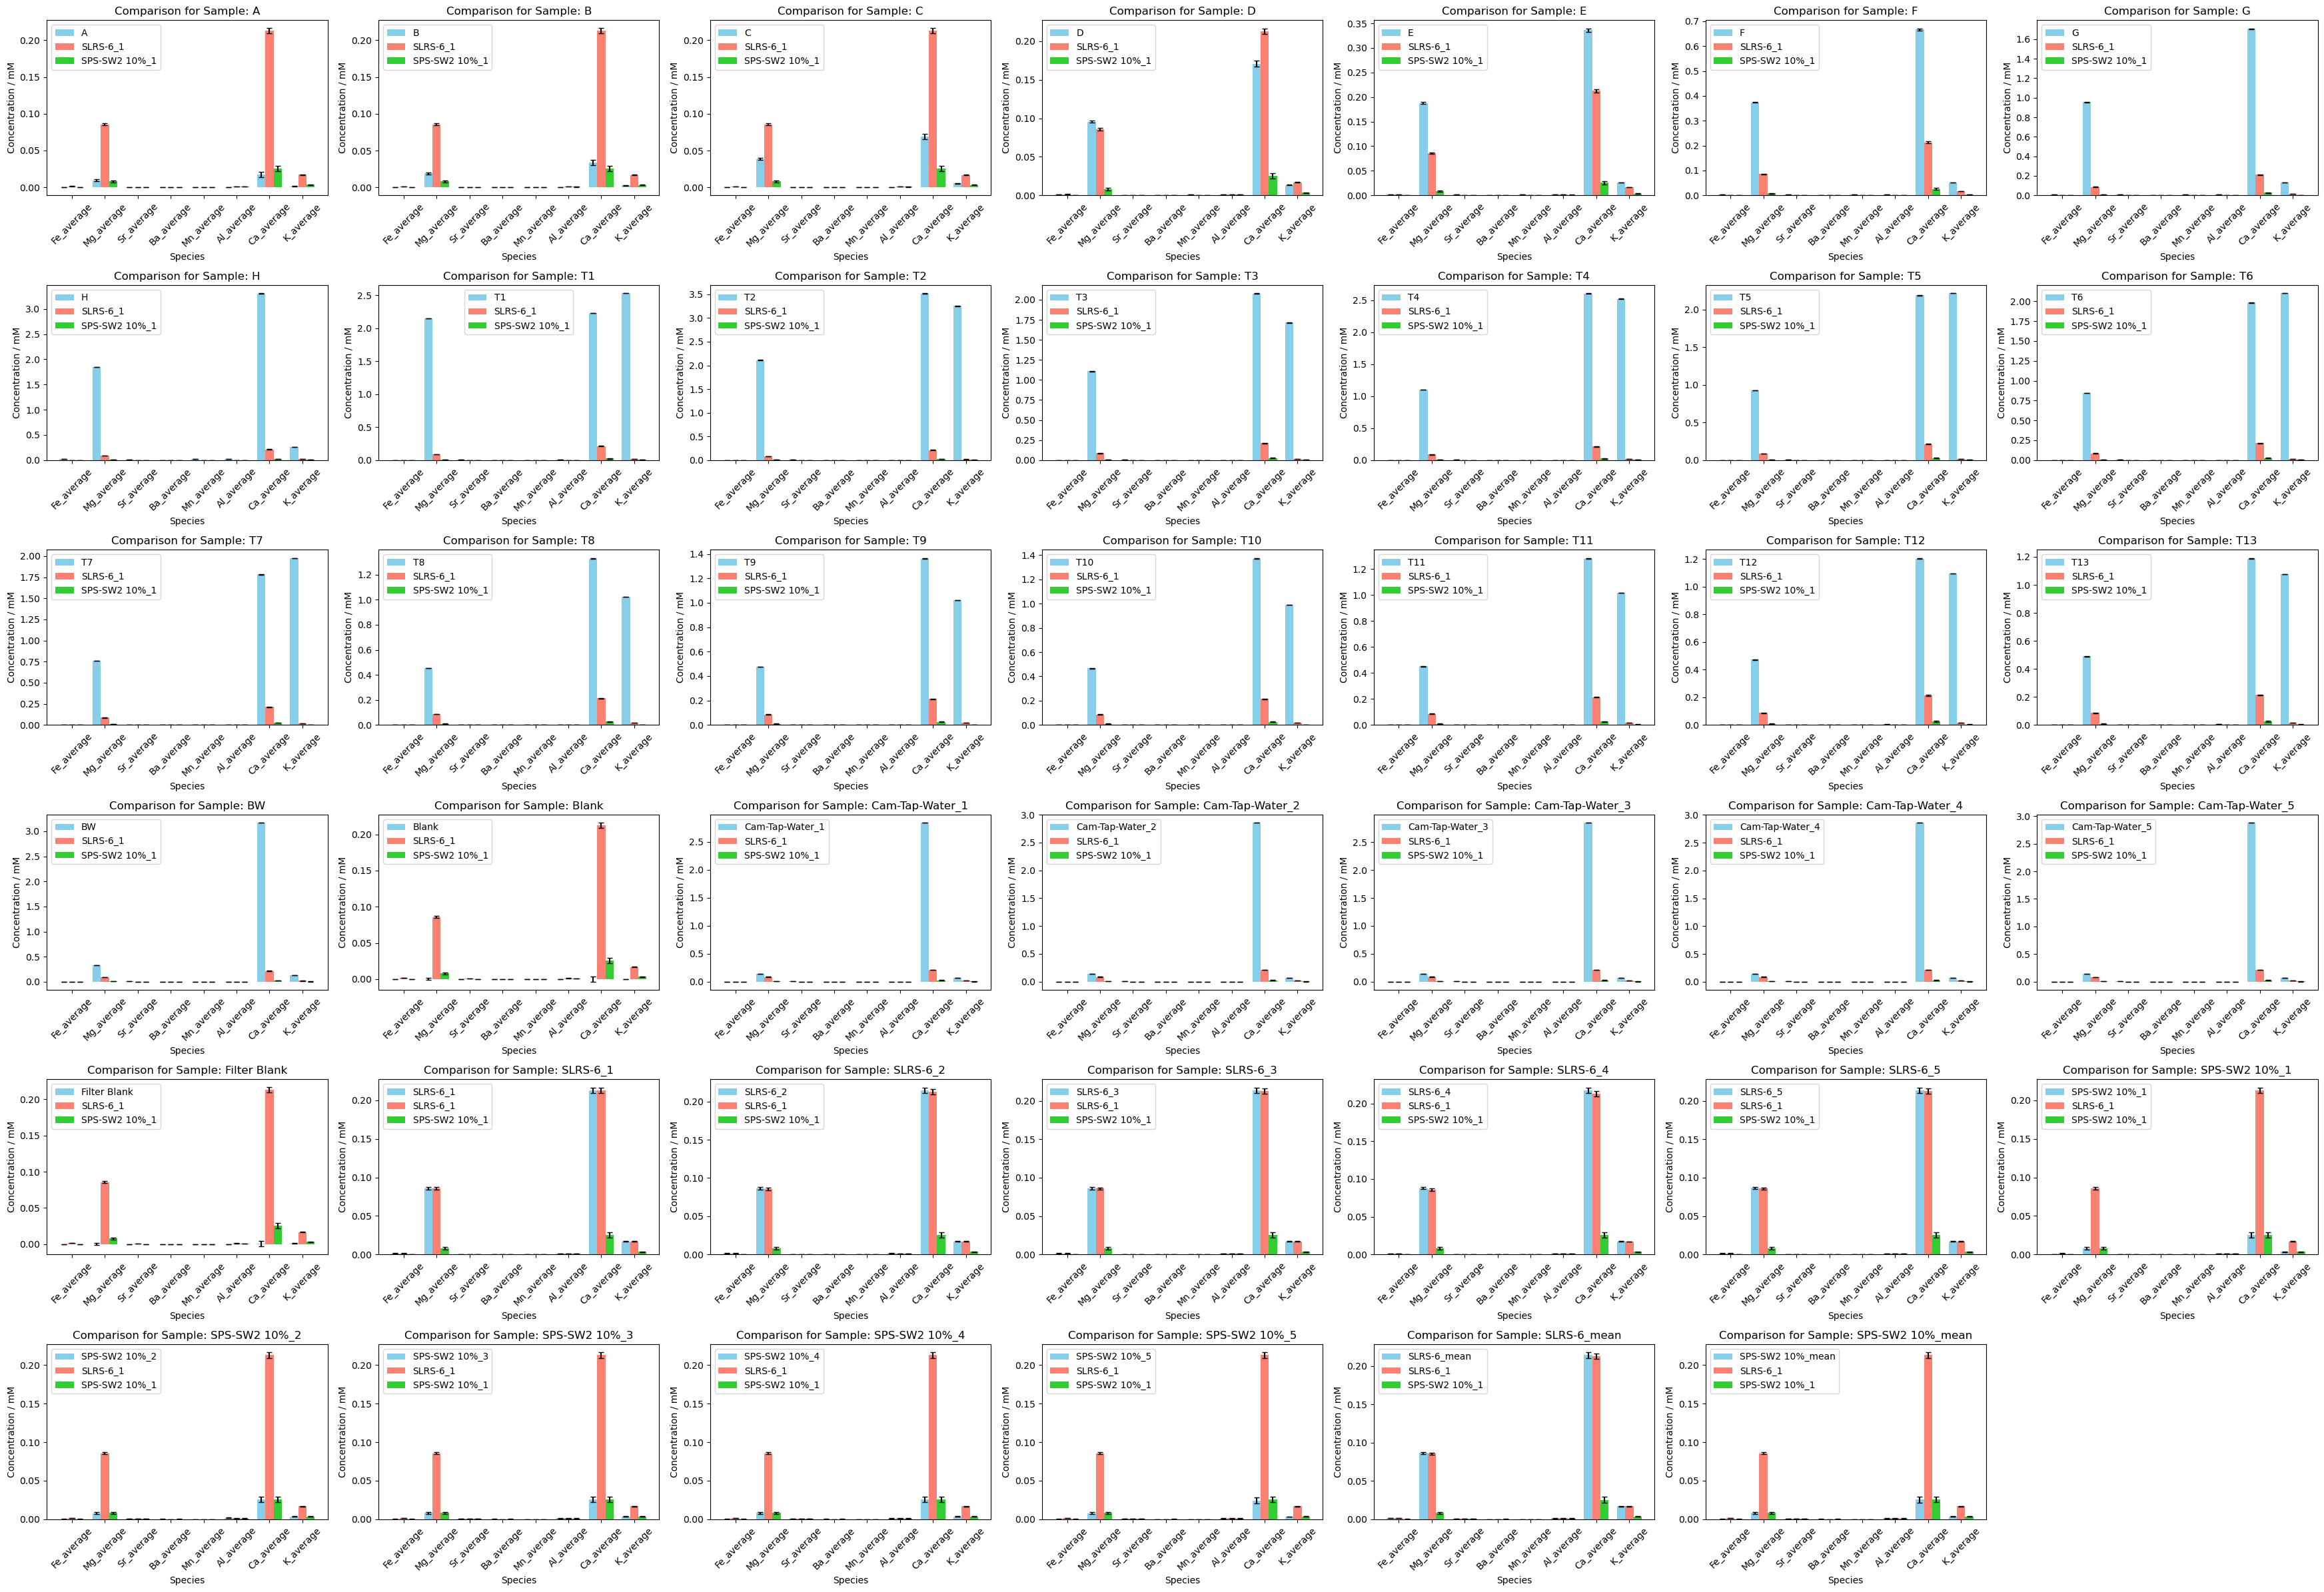

In [39]:
fig = bar_by_sample(ds)
plt.show()  # display the figure


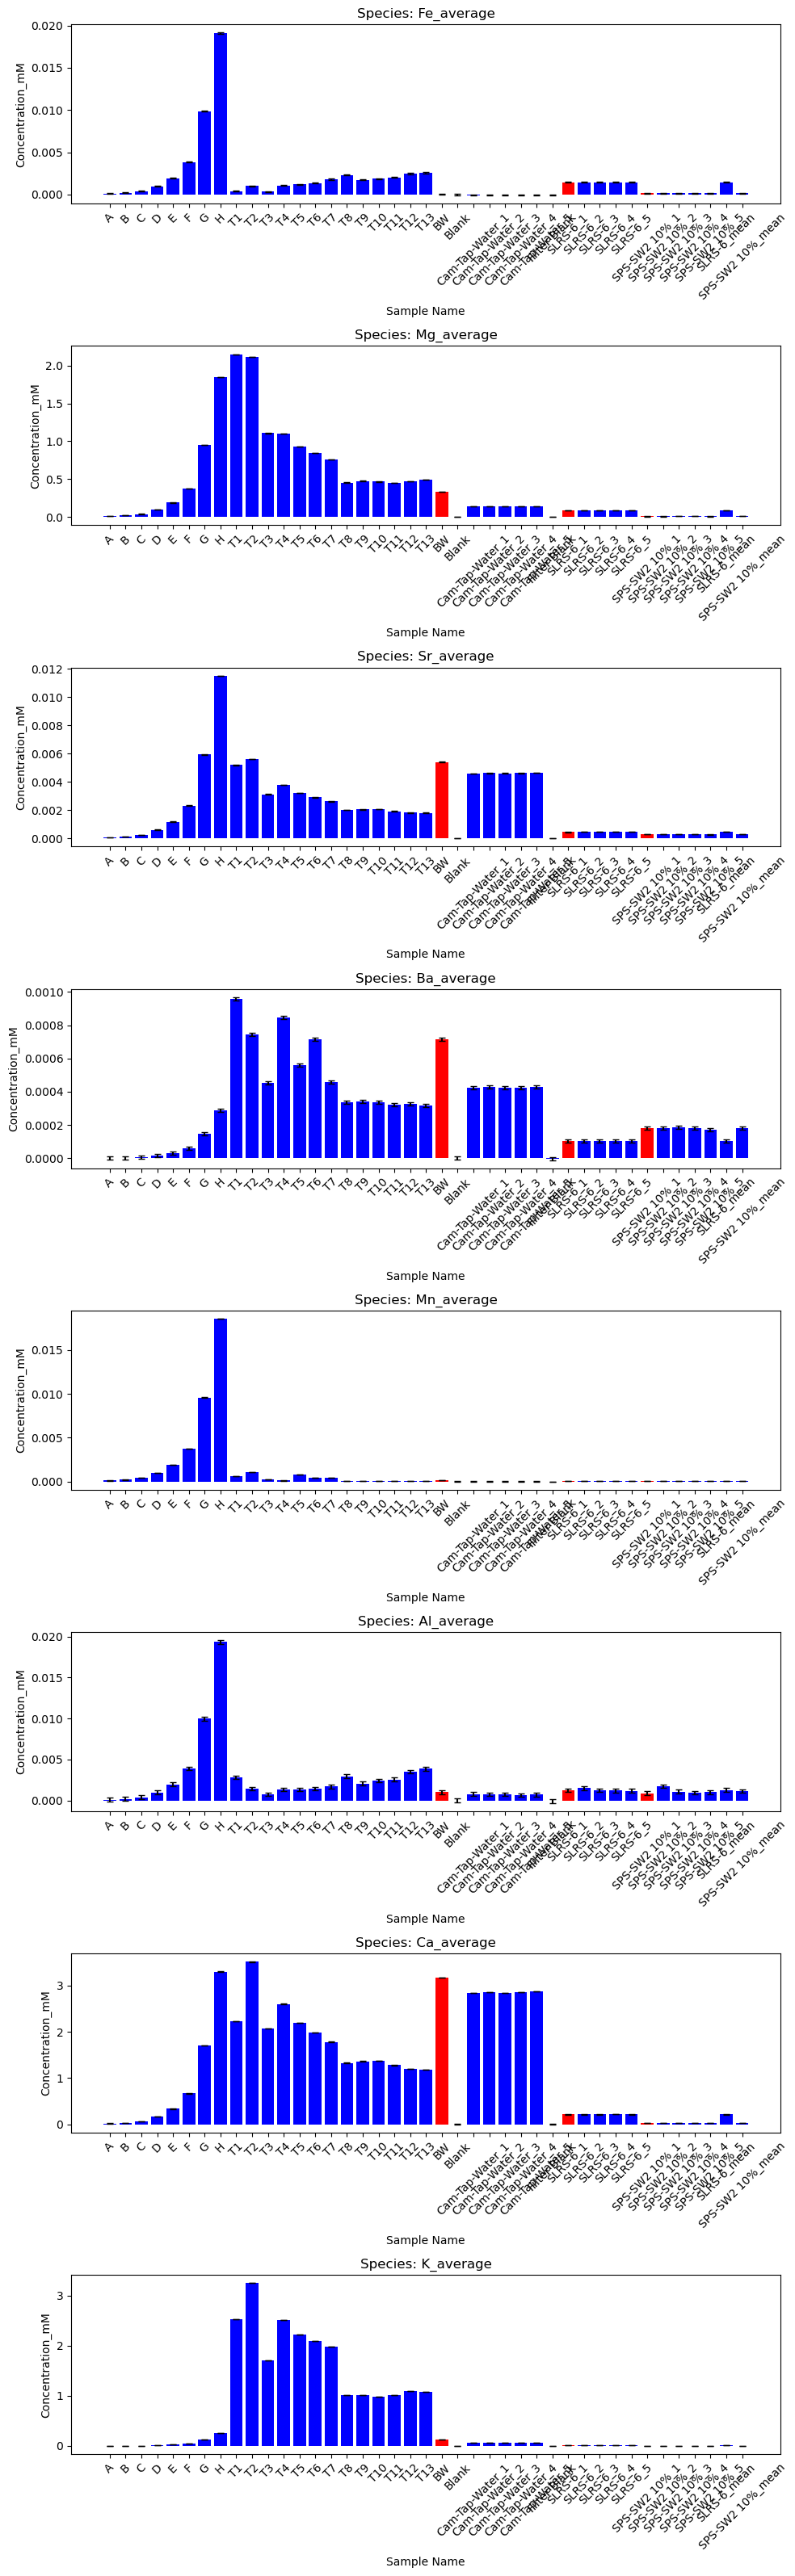

In [41]:
# Get the figure with bar charts for each species, highlighting 'sampleA' and 'sampleC'
bar_by_species(ds, var_name='Concentration_mM', comp_samples=['SLRS-6_1', 'SPS-SW2 10%_1', 'BW'])

# To display the figure, you can call:
plt.show()



In [ ]:
import xarray as xr
import numpy as np


# Call the function.
results = find_dilutions(ds, 'Concentration_mM')


Sample: T1
Largest species outside calibration: K_average, Required dilution ratio: 9.79
Other species outside of calibration: ['Mg_average', 'Ba_average']
-----------------------------------
Sample: T2
Largest species outside calibration: K_average, Required dilution ratio: 12.59
Other species outside of calibration: ['Mg_average', 'Ba_average', 'Ca_average']
-----------------------------------
Sample: T3
Largest species outside calibration: K_average, Required dilution ratio: 6.63
Other species outside of calibration: ['Ba_average']
-----------------------------------
Sample: T4
Largest species outside calibration: K_average, Required dilution ratio: 9.76
Other species outside of calibration: ['Ba_average']
-----------------------------------
Sample: T5
Largest species outside calibration: K_average, Required dilution ratio: 8.58
Other species outside of calibration: ['Ba_average']
-----------------------------------
Sample: T6
Largest species outside calibration: K_average, Required

Means for Mg_average
Diluted samples mean: 0.1578773703703704
Undiluted samples mean: 2.1735714102564114
Max conc. at proposed dilution: 0.34842155555555554
----------
Means for Ca_average
Diluted samples mean: 0.5528373067632851
Undiluted samples mean: 3.849542666666667
Max conc. at proposed dilution: 0.9397933333333335
----------
Means for K_average
Diluted samples mean: 0.42430257142857153
Undiluted samples mean: 1.1676296296296296
Max conc. at proposed dilution: 0.8475769999999999
----------


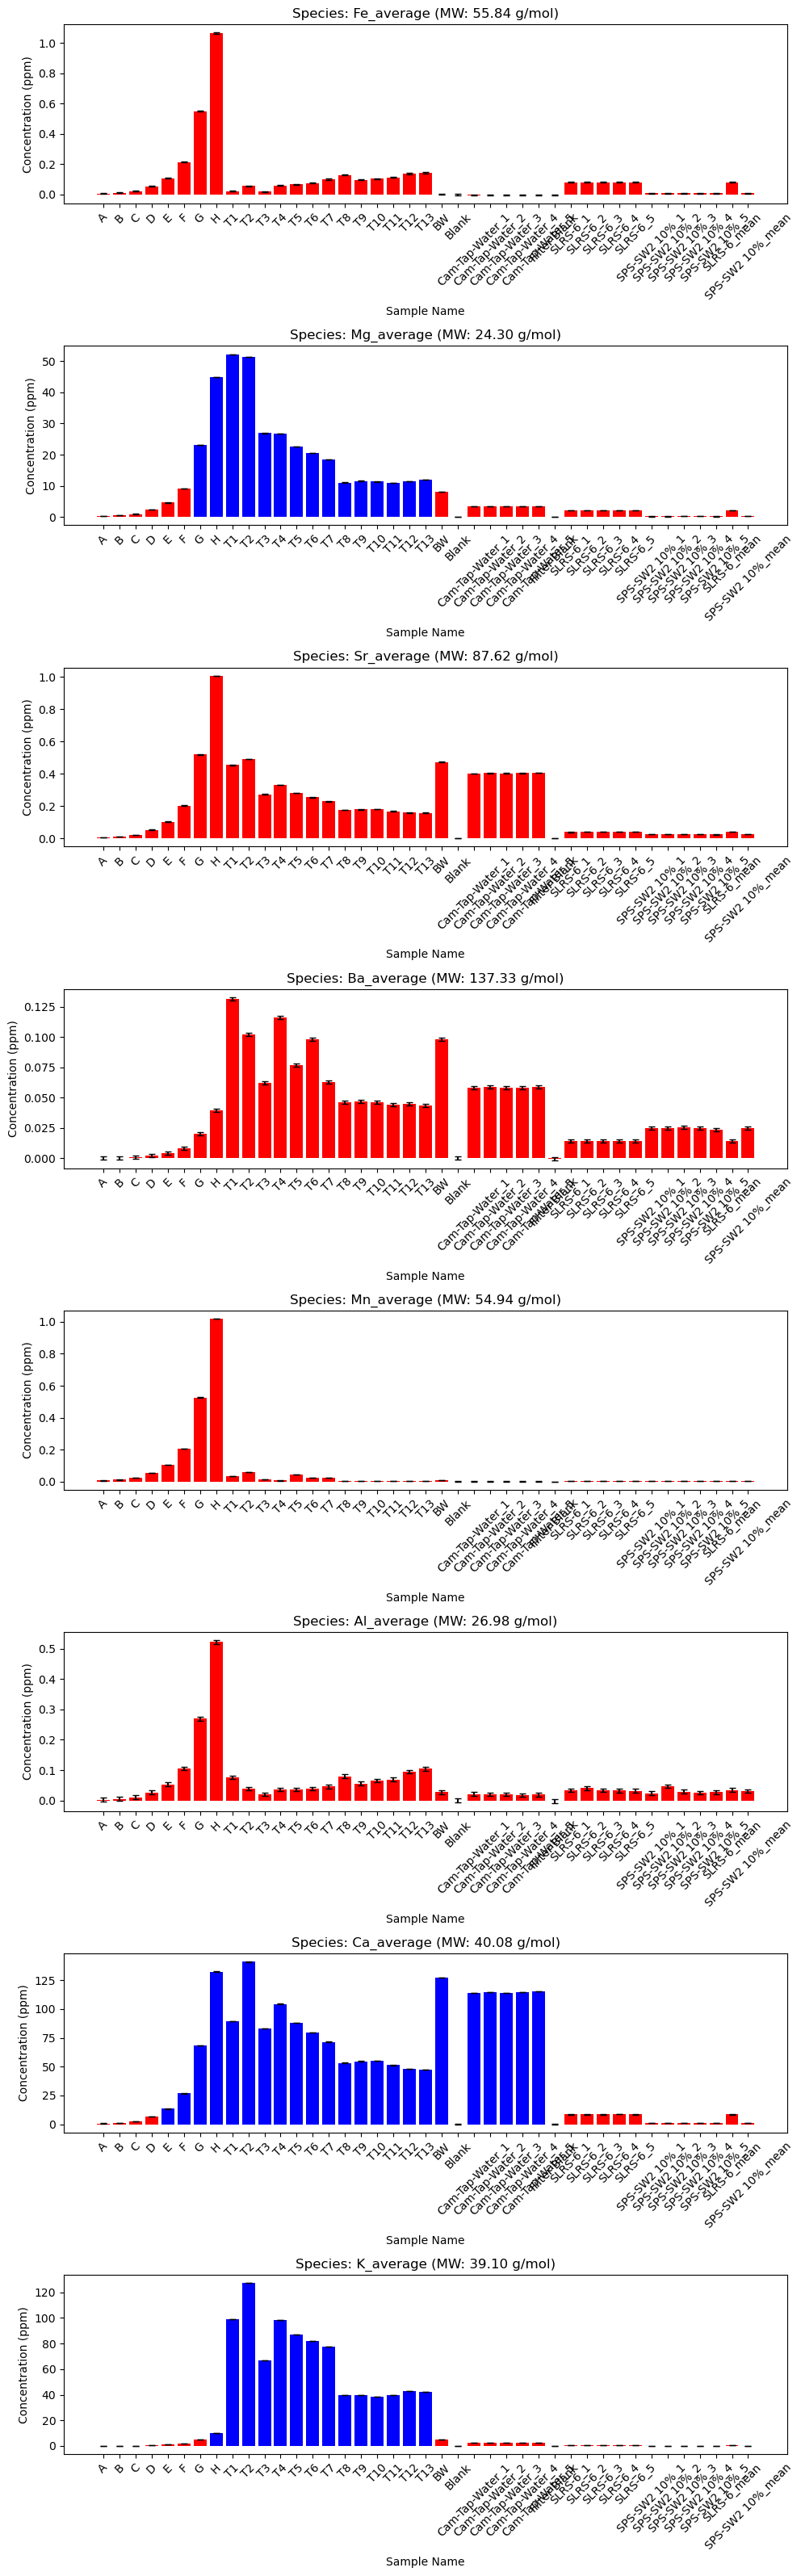

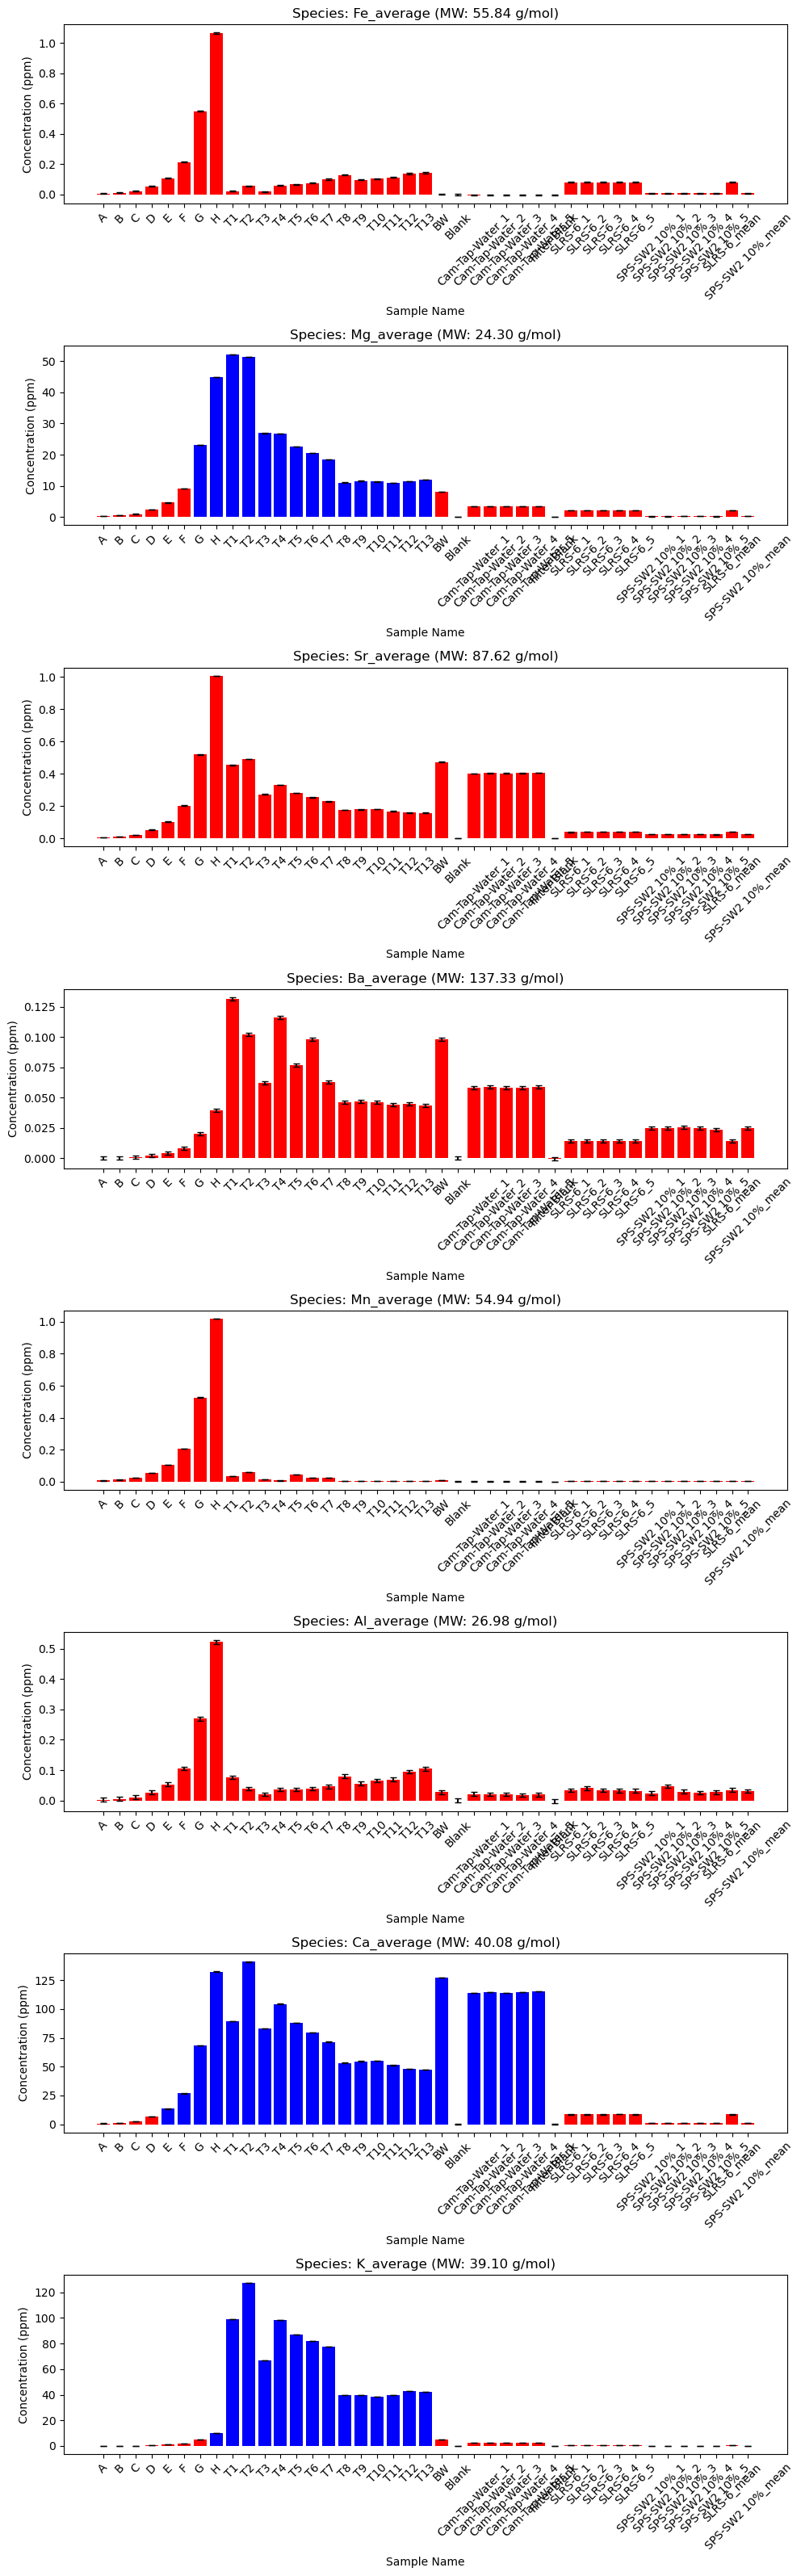

In [ ]:
import matplotlib.pyplot as plt

ELEMENTAL_MOLAR_MASSES = {
    "H": 1.00784,
    "He": 4.002602,
    "Li": 6.94,
    "Be": 9.012182,
    "B": 10.81,
    "C": 12.0107,
    "N": 14.0067,
    "O": 15.999,
    "F": 18.998403163,
    "Ne": 20.1797,
    "Na": 22.98976928,
    "Mg": 24.305,
    "Al": 26.9815385,
    "Si": 28.085,
    "P": 30.973761998,
    "S": 32.06,
    "Cl": 35.45,
    "Ar": 39.948,
    "K": 39.0983,
    "Ca": 40.078,
    "Mn": 54.938,    # Manganese
    "Fe": 55.845,    # Iron
    "Sr": 87.62,     # Strontium
    "Ba": 137.327,   # Barium
    # Add more elements as needed
}


def bar_by_species_ppm(ds, var_name="Concentration_mM", comp_samples=None):
    """
    Plot bar charts for each species from an xarray dataset with concentrations converted to ppm.
    
    This function expects the dataset to have two coordinates: 'sample_name' and 'species', and
    the following variables:
      - 'Concentration_mM': the concentration data (in mM) with dimensions ('species', 'sample_name')
      - 'error': the error values (with dimensions matching 'Concentration_mM')
      - Elemental composition variables: if available, variables named '{ELEMENT_SYMBOL}_average'
        (e.g., 'C_average', 'H_average', etc.) representing the average count of that element in the species.
    
    For each species, the molecular weight (MW) is calculated as:
    
        MW = Σ (element_count × atomic_mass)
    
    The mM concentration is then converted to ppm (≈ mg/L) using:
    
        ppm = mM × MW
    
    If no elemental composition data is available for a species, a default MW of 1 g/mol is used.
    
    Parameters
    ----------
    ds : xarray.Dataset
        A dataset with coordinates 'sample_name' and 'species' and variables 'Concentration_mM',
        'error', and optionally elemental composition variables like 'C_average', 'H_average', etc.
    var_name : str, optional
        The variable name for concentrations in the dataset (default is 'Concentration_mM').
    comp_samples : list of str, optional
        A list of sample names to highlight (drawn in red). All other samples are drawn in blue.
    
    Returns
    -------
    fig : matplotlib.figure.Figure
        The figure object containing the subplots.
    """
    if comp_samples is None:
        comp_samples = []
    
    species_list = ds.coords['species'].values
    n_species = len(species_list)
    
    fig, axes = plt.subplots(n_species, 1, figsize=(10, 4 * n_species), squeeze=False)
    
    for i, species in enumerate(species_list):
        ax = axes[i, 0]
        
        # Compute the molecular weight for the current species using available elemental data.
        mw_computed = 0.0

        species_element = species.split('_')
        mw_computed = ELEMENTAL_MOLAR_MASSES[species_element[0]]

        # If no elemental data is available, use a default molecular weight of 1 g/mol.
        if mw_computed == 0:
            factor = 1.0
        else:
            factor = mw_computed
        
        # Select the concentration and error data for the current species.
        data = ds[var_name].sel(species=species)
        error_data = ds['error'].sel(species=species).values
        
        sample_names = data.coords['sample_name'].values
        values_mM = data.values
        
        # Convert concentrations from mM to ppm.
        values_ppm = values_mM * factor
        error_ppm = error_data * factor
        
        dilution_factor = 150

        # Set bar colors: red for highlighted samples, blue for others.
        colors = ['red' if value < 10 else 'blue' for value in values_ppm]
        if species in ['Ca_average', 'K_average', 'Mg_average', 'Na_average']:
            undilute_sum = 0
            dilute_sum = 0
            undilute = 0
            dilute = 0
            for value in values_ppm:
                if value < 10:
                    undilute_sum += value
                    undilute += 1
                elif value > 10:
                    dilute_sum += value / dilution_factor
                    dilute += 1
            print(f'Means for {species}')
            print(f'Diluted samples mean: {dilute_sum / dilute}')
            print(f'Undiluted samples mean: {undilute_sum / undilute}')
            print(f'Max conc. at proposed dilution: {values_ppm.max() / dilution_factor}')
            print('----------')
        #print(values_ppm.max())
        ax.bar(sample_names, values_ppm, color=colors, yerr=error_ppm, capsize=3)
        ax.set_title(f"Species: {species} (MW: {factor:.2f} g/mol)")
        ax.set_xlabel("Sample Name")
        ax.set_ylabel("Concentration (ppm)")
        ax.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    return fig

bar_by_species_ppm(ds)